In [1]:
try:
    # On Google Colab
    from google.colab import drive

    drive.mount("/content/drive")

    BASEDIR = (
        "drive/MyDrive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/model2024/"
    )
    ! pip install japanize_matplotlib
except:
    BASEDIR = "./"


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import scipy

P の変動の様子をプロットする。


In [55]:
bridge = "昭和橋"
river_P = pd.read_csv(f"{BASEDIR}../flow/{bridge}.P.csv")
river_N = pd.read_csv(f"{BASEDIR}../flow/{bridge}.N.csv")
river_flow = pd.read_csv(f"{BASEDIR}../flow/{bridge}.flow.csv")
# datetimeに変換し、分を省く
river_P.datetime = pd.to_datetime(river_P.datetime).dt.floor("h")
river_N.datetime = pd.to_datetime(river_N.datetime).dt.floor("h")
river_flow.datetime = pd.to_datetime(river_flow.datetime).dt.floor("h")

窒素とりんは連動するか。とくに、その切片を見ると、大気質由来の窒素量がわかるかもしれない。(リンは大気には由来しないので)


0.8534912411725643


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_41258/1999096371.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


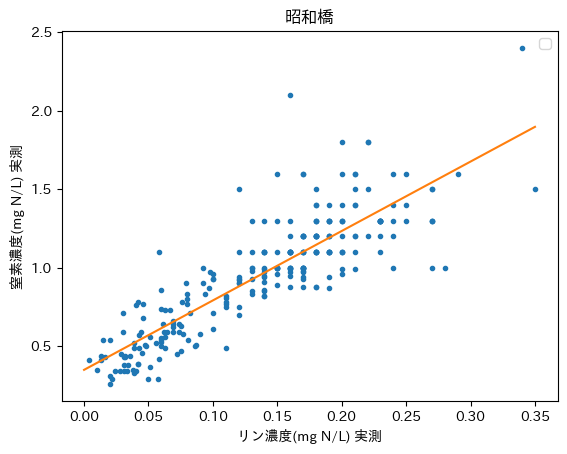

In [56]:
plt.plot(river_P.value, river_N.value, ".")
print(np.corrcoef(river_P.value, river_N.value)[0, 1])
plt.title(bridge)
plt.xlabel("リン濃度(mg N/L) 実測")
plt.ylabel("窒素濃度(mg N/L) 実測")
plt.legend()
(AA, BB), pcov = scipy.optimize.curve_fit(
    lambda x, A, B: A * x + B, river_P.value, river_N.value
)
X = np.linspace(0, river_P.value.max(), 100)
Y = AA * X + BB
plt.plot(X, Y)

In [57]:
flowP = pd.merge(
    river_flow[["datetime", "value"]],
    river_P[["datetime", "value"]],
    on="datetime",
    how="left",
)
flowPN = pd.merge(
    flowP, river_N[["datetime", "value"]], on="datetime", how="left"
).dropna()
flowPN.columns = ["datetime", "flow", "P", "N"]
flowPN

,datetime,flow,P,N
24,2002-04-17 12:00:00+09:00,1.5500,0.20,1.10
25,2002-05-08 12:00:00+09:00,0.9600,0.22,1.80
26,2002-06-05 12:00:00+09:00,1.2200,0.16,2.10
27,2002-07-04 12:00:00+09:00,1.4100,0.18,1.10
28,2002-08-07 12:00:00+09:00,1.2200,0.23,1.30
...,...,...,...,...
202,2017-02-16 12:00:00+09:00,1.3340,0.18,1.10
203,2017-03-09 12:00:00+09:00,1.3026,0.16,0.97
204,2017-04-13 12:00:00+09:00,1.3383,0.15,1.00
205,2017-05-11 12:00:00+09:00,1.0490,0.17,0.93


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_41258/2065047884.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


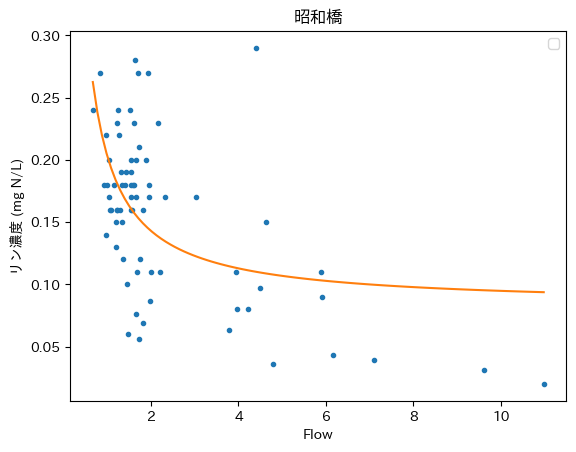

NameError: name 'A' is not defined

In [58]:
plt.plot(flowPN.flow, flowPN.P, ".")
plt.title(bridge)
plt.xlabel("Flow")
plt.ylabel("リン濃度 (mg N/L)")
popt, pcov = scipy.optimize.curve_fit(
    lambda Fr, D, E: D / Fr + E, flowPN.flow, flowPN.P
)
D, E = popt
X = np.linspace(flowPN.flow.min(), flowPN.flow.max(), 100)
Y = D / X + E
plt.plot(X, Y, "-")
plt.legend()
plt.show()
print(A, B, np.corrcoef(flowPN.flow, flowPN.P))

流量に対しては、濃度ほぼ一定。


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_41258/744300362.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


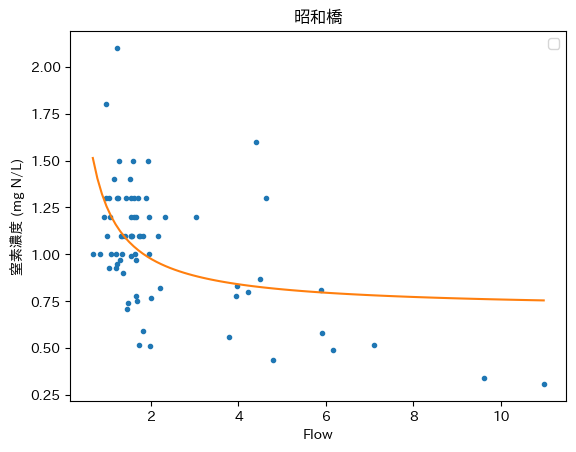

0.5413598623065307 0.7056168153724789 [[ 1.         -0.54708326]
 [-0.54708326  1.        ]]


In [59]:
plt.plot(flowPN.flow, flowPN.N, ".")
plt.title(bridge)
plt.xlabel("Flow")
plt.ylabel("窒素濃度 (mg N/L)")
popt, pcov = scipy.optimize.curve_fit(
    lambda Fr, D, E: D / Fr + E, flowPN.flow, flowPN.N
)
D, E = popt
X = np.linspace(flowPN.flow.min(), flowPN.flow.max(), 100)
Y = D / X + E
plt.plot(X, Y, "-")
plt.legend()
plt.show()
print(D, E, np.corrcoef(flowPN.flow, flowPN.N))

年周変化やトレンドを見る。


Text(0.5, 1.0, '昭和橋 P')

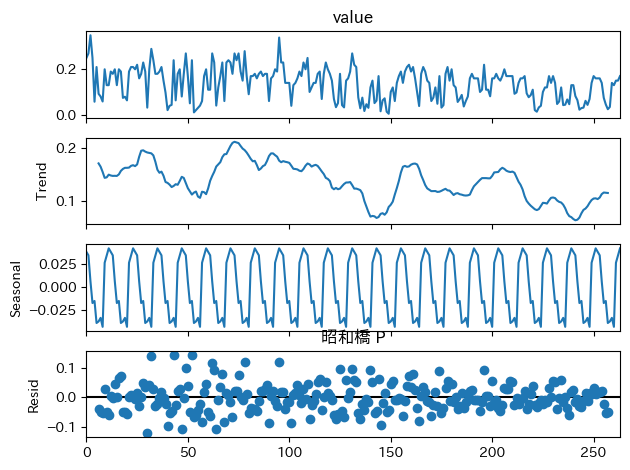

In [60]:
import numpy as np
import scipy
import japanize_matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.filters.hp_filter import hpfilter

decomposed = seasonal_decompose(river_P.value, model="additive", period=12)
plot = decomposed.plot()
plt.title(f"{bridge} P")

Text(0.5, 1.0, '昭和橋 N')

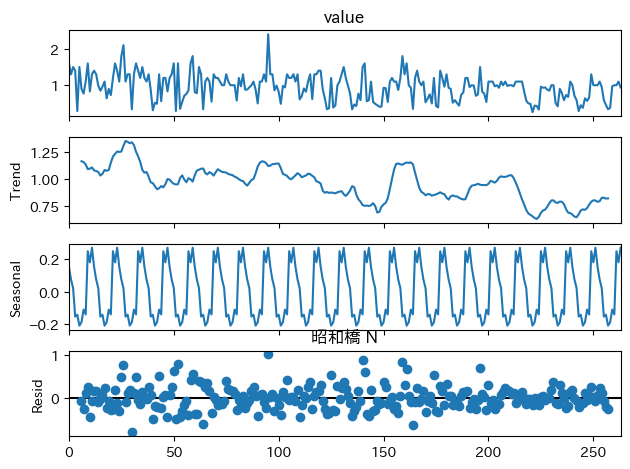

In [61]:
decomposed = seasonal_decompose(river_N.value, model="additive", period=12)
plot = decomposed.plot()
plt.title(f"{bridge} N")

昭和橋では、河川窒素と河川リンがよく相関していたので、排水リン濃度から排水窒素濃度も予想できると仮定したが、その場合、排水リンと大気窒素が相関していないことを確認しておく必要がある。

この確認がとれれば、河川リン濃度から排水窒素濃度を予測して構わないと言える。


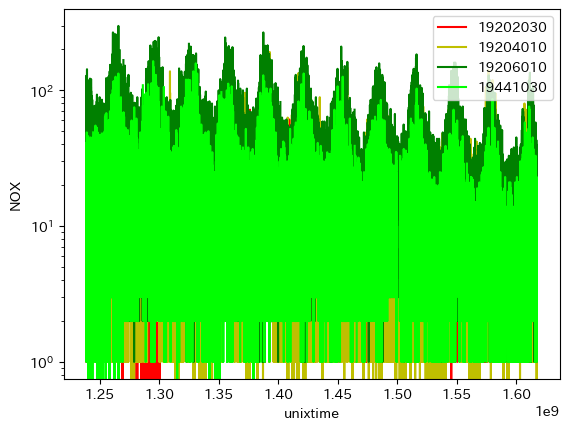

          unixtime                  datetime  19202030  19204010  19206010  \
0       1238511600 2009-04-01 00:00:00+09:00       9.0      21.0      27.0   
1       1238515200 2009-04-01 01:00:00+09:00       7.0      21.0      34.0   
2       1238518800 2009-04-01 02:00:00+09:00       7.0      18.0      37.0   
3       1238522400 2009-04-01 03:00:00+09:00       8.0      18.0      24.0   
4       1238526000 2009-04-01 04:00:00+09:00       8.0      22.0      26.0   
...            ...                       ...       ...       ...       ...   
105187  1617184800 2021-03-31 19:00:00+09:00       6.0       5.0       8.0   
105188  1617188400 2021-03-31 20:00:00+09:00       4.0       4.0       8.0   
105189  1617192000 2021-03-31 21:00:00+09:00       4.0       4.0      10.0   
105190  1617195600 2021-03-31 22:00:00+09:00       3.0       6.0       8.0   
105191  1617199200 2021-03-31 23:00:00+09:00       5.0       6.0       8.0   

        19441030  
0           22.0  
1           12.0  
2     

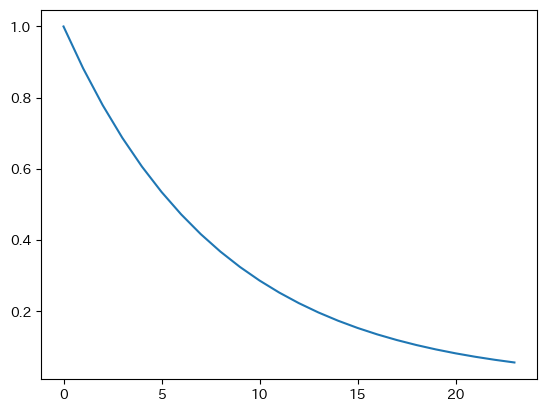

In [62]:
# 指定された局の、全期間のNOX値を抽出する。

fig, ax = plt.subplots()
ax.set_ylabel("NOX")

stations = {"19202030": "r", "19204010": "y", "19206010": "g", "19441030": "lime"}

nox = []
for station in stations:
    dfs = []
    for year in range(2009, 2021):
        with open(f"{BASEDIR}../air/19/{year}/j19{year}_{station}.csv") as f:
            df = pd.read_csv(f, parse_dates=[1])  # parse date time in column 1
            dfs.append(df)

    dfs = pd.concat(dfs)

    dfs["datetime"] = pd.to_datetime(dfs["date"]).dt.tz_localize("Asia/Tokyo")
    dfs["unixtime"] = dfs["datetime"].astype(int) // 10**9
    dfs.index = dfs.unixtime
    if len(nox) == 0:
        nox.append(dfs.datetime)

    # print(dfs.head())
    # 月単位にグループ化します。
    # grouped_df = dfs["NOX"].groupby(pd.Grouper(level="date", freq="M"))

    # 各グループの平均値を計算します。
    # mean_df = grouped_df.mean()
    mean_df = dfs["NOX"]

    # 結果を表示します。
    # print(mean_df)
    mean_df.plot(color=stations[station], ax=ax, label=station)
    nox.append(mean_df)


nox = pd.concat(nox, axis=1)
nox.columns = ["datetime"] + list(stations)
nox = nox.reset_index(drop=False)

# plt.plot(mean_df["NOX"])
plt.yscale("log")
plt.legend()
plt.show()
print(nox)


# インパルス応答は6時間で1/eに落ちる減衰関数。
decay_time = 8  # hours
lookback = 24
xtick = np.arange(0, lookback)
impulse_response = np.exp(-xtick / decay_time)

# decay_time = "-"  # hours
# impulse_response = 6 / (xtick + 1) ** 0.65 - 15000 / (xtick + 5) ** 5
plt.plot(impulse_response)
plt.show()

/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/model2024/../level/level.py:73: RuntimeWarning: invalid value encountered in divide
  X_ = np.zeros([L, lookback]) / 0


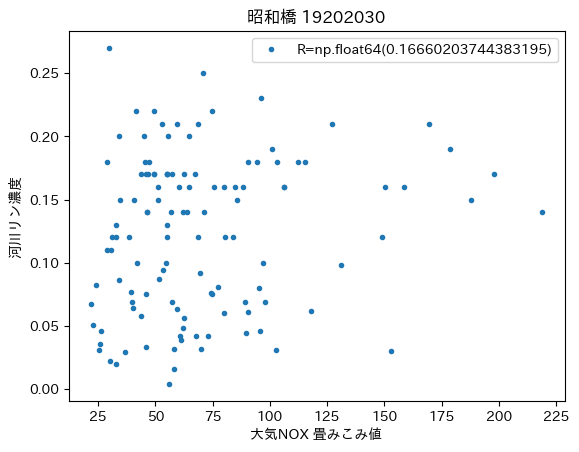

In [63]:
import sys

sys.path.insert(0, "..")
from 神奈川県河港課水位雨量データ.reader import delayed_data

station = "19202030"
nox_delay = delayed_data(nox[station], lookback=lookback)[:, ::-1]  # 左右反転しておく。
# 時刻がずれると困るので、pandasに戻す。
nox_delay = pd.DataFrame(nox_delay)
# print(w.shape, 大月雨量.shape)
nox_delay = pd.concat([nox.reset_index(drop=False).datetime, nox_delay], axis=1)
# print(nox_delay)
nox_delay = nox_delay.dropna(axis=0, how="any")

c = pd.merge(river_N, nox_delay, on="datetime", how="left")

# インパルス応答で畳みこんだ大気窒素濃度
wc = c.to_numpy()[:, -lookback:].astype(float) @ impulse_response

R = np.corrcoef(wc[~np.isnan(wc)], river_P.value[~np.isnan(wc)])[0, 1]
plt.plot(wc, river_P.value, ".", label=f"{R=}")
plt.title(f"{bridge} {station}")
plt.xlabel("大気NOX 畳みこみ値")
plt.ylabel("河川リン濃度")
plt.legend()

弱いけど、相関はある。なぜ?

- 流量を介して相関している?
- 年周変化が一致している?
